### Import packages

In [32]:
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import pickle5 as pickle


### Prepare data for training and testing the model

In [33]:

# Prepare data for training and testing the model
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    '''
        ImageDataGenerator
        - Generate batches of tensor image data with real-time data augmentation.
        
            - Image augmentation is a technique of altering the existing data to create some more data for the model training process. In other words, 
            it is the process of artificially expanding the available dataset for training a deep learning model.

    '''    
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test



In [34]:
image_height = 64
image_width = 64

### Prepare Model

In [35]:
# def create_model():

#     model = Sequential()
#     model.add(Conv2D(32, kernel_size = (3,3), input_shape = (image_height, image_width, 3), activation = 'relu', padding = 'same'))
#     # model.add(MaxPool2D(pool_size = (2,2)))
#     model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#     model.add(MaxPool2D(pool_size = (2,2)))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#     # model.add(MaxPool2D(pool_size = (2,2)))
#     model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))

#     model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
#     model.add(Dropout(0.4))

#     # model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#     # model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
#     # model.add(Dropout(0.3))

#     # model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#     # model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

#     # model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#     # model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

#     model.add(Flatten())

#     # model.add(Dense(16, activation = 'relu'))

#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
    
#     model.add(Dense(8, activation='softmax')) # 8 = number of classes

#     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

#     model.compile(loss = 'sparse_categorical_crossentropy',
#                  optimizer = optimizer,
#                   metrics = ['accuracy'])
#     print(model.summary())
#     return model;

In [36]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (64, 64, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;


### Train Model

In [37]:
def train_model(model, X_train, Y_train, EPOCHS=25):

    '''
        EarlyStoopping - Stop training when a monitored metric has stopped improving
    '''
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    '''
        ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the 
                            learning rate by a factor of 2-10 once learning stagnates.
    '''
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

### Test Model

In [38]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

In [39]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):

    '''
        Confusion Matrix is used to know the performance of a Machine learning classification. It is represented in a matrix form.

        Confusion Matrix gives a comparison between Actual and predicted values.

        The confusion matrix is a N x N matrix, where N is the number of classes or outputs.

        For 2 class ,we get 2 x 2 confusion matrix.

        For 3 class ,we get 3 X 3 confusion matrix.
    '''
    #Get the true and predicted labels
    # y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    
    # plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name)

In [40]:
# base_skin_dir = os.path.join('./Datasets/HAM10000/HAM10000_train', 'input')
# base_skin_dir = os.path.join('..', 'input')
# print(base_skin_dir)

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join("./Datasets/HAM10000/HAM10000_train/", '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)',
    'ben': 'Benign'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df',
    7:'ben'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())
imageid_path_dict

{'63': './Datasets/HAM10000/HAM10000_train/63.jpg',
 'ISIC_0030858': './Datasets/HAM10000/HAM10000_train/ISIC_0030858.jpg',
 'ISIC_0030680': './Datasets/HAM10000/HAM10000_train/ISIC_0030680.jpg',
 '823': './Datasets/HAM10000/HAM10000_train/823.jpg',
 'ISIC_0033389': './Datasets/HAM10000/HAM10000_train/ISIC_0033389.jpg',
 'ISIC_0032097': './Datasets/HAM10000/HAM10000_train/ISIC_0032097.jpg',
 'ISIC_0032929': './Datasets/HAM10000/HAM10000_train/ISIC_0032929.jpg',
 '1409': './Datasets/HAM10000/HAM10000_train/1409.jpg',
 'ISIC_0026784': './Datasets/HAM10000/HAM10000_train/ISIC_0026784.jpg',
 'ISIC_0028971': './Datasets/HAM10000/HAM10000_train/ISIC_0028971.jpg',
 'ISIC_0026948': './Datasets/HAM10000/HAM10000_train/ISIC_0026948.jpg',
 'ISIC_0026790': './Datasets/HAM10000/HAM10000_train/ISIC_0026790.jpg',
 '189': './Datasets/HAM10000/HAM10000_train/189.jpg',
 'ISIC_0028965': './Datasets/HAM10000/HAM10000_train/ISIC_0028965.jpg',
 'ISIC_0025299': './Datasets/HAM10000/HAM10000_train/ISIC_002529

### Read metadata csv

In [41]:
data = pd.read_csv(os.path.join('./Datasets/HAM10000/archive/HAM10000_metadata.csv'))
data.tail()


,lesion_id,image_id,dx,dx_type,age,sex,localization
11804,HAM_0051789,1796,ben,histo,60.0,male,face
11805,HAM_0051790,1797,ben,histo,60.0,male,face
11806,HAM_0051791,1798,ben,histo,50.0,female,face
11807,HAM_0051792,1799,ben,histo,70.0,female,hand
11808,HAM_0051793,1800,ben,histo,45.0,male,face


In [42]:
# Describes the data
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,11809,11809,11809,11809,11809,11809
unique,9264,11809,8,4,3,15
top,HAM_0001863,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,7134,6345,2281


In [43]:
# Check for null
data.isnull().any().sum()

# If null we need imputing because By imputation, we mean to replace the missing or null values with a particular value in the entire dataset.
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

# Adding cell_type and image_path columns in CSV
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002741...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002503...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002676...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002566...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_003163...


In [44]:
# Adding image pixels in CSV
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((image_width,image_height))))
data.head(4)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002741...,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002503...,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002676...,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002566...,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."


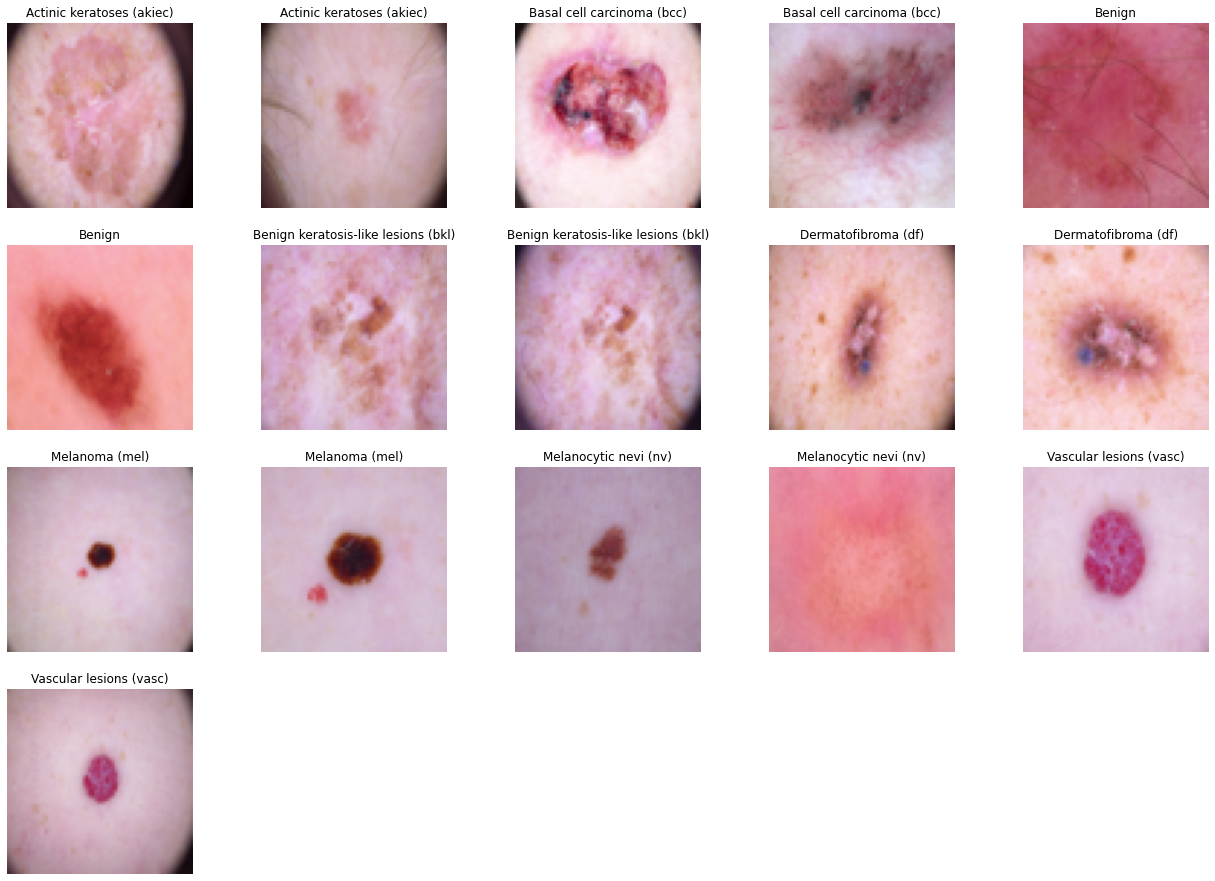

In [45]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(16):
    plt.subplot(8, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [46]:

data['label'] = data['dx'].map(reverse_label_mapping.get)
data = data.reset_index()
data.head()


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002741...,"[[[191, 152, 194], [191, 153, 195], [192, 149,...",2
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002503...,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6...",2
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002676...,"[[[186, 129, 140], [192, 136, 151], [198, 143,...",2
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002566...,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9...",2
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_003163...,"[[[139, 95, 118], [158, 114, 138], [178, 133, ...",2


In [47]:


counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
final_data = pd.concat(frames)
final_data.head()

/var/folders/bq/rchhhlqs4jlfz0nr2r4mx0wm0000gn/T/ipykernel_13364/2192529332.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index = df_index.append([df_index]*i, ignore_index = True)


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002741...,"[[[191, 152, 194], [191, 153, 195], [192, 149,...",2
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002503...,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6...",2
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002676...,"[[[186, 129, 140], [192, 136, 151], [198, 143,...",2
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_002566...,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9...",2
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),./Datasets/HAM10000/HAM10000_train/ISIC_003163...,"[[[139, 95, 118], [158, 114, 138], [178, 133, ...",2


In [48]:
print(data.shape)
print(final_data.shape)

(11809, 12)
(128670, 12)


In [49]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(11809, 64, 64, 3)
(11809, 1)


In [50]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)


(128670, 64, 64, 3)
(128670, 1)


In [51]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [52]:
model =create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)        

In [53]:
# For augmented data
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [54]:
print(X_train_aug.shape[0:])

(102936, 64, 64, 3)


In [55]:
#Train augmented data
model2_history = train_model(model, X_train_aug, Y_train_aug, 5)

Epoch 1/5
1287/1287 [==============================] - 67s 52ms/step - loss: 0.9169 - accuracy: 0.7080 - val_loss: 0.6216 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 2/5
1287/1287 [==============================] - 73s 57ms/step - loss: 0.4179 - accuracy: 0.8611 - val_loss: 0.3016 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/5
1287/1287 [==============================] - 75s 58ms/step - loss: 0.2680 - accuracy: 0.9162 - val_loss: 0.2251 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 4/5
1287/1287 [==============================] - 76s 59ms/step - loss: 0.2021 - accuracy: 0.9399 - val_loss: 0.1668 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 5/5
1287/1287 [==============================] - 77s 60ms/step - loss: 0.1647 - accuracy: 0.9531 - val_loss: 0.1385 - val_accuracy: 0.9630 - lr: 0.0010


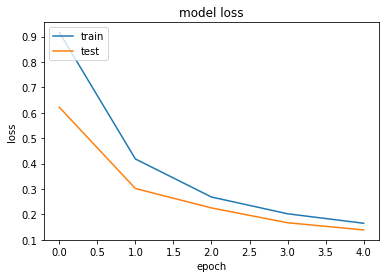

In [56]:
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

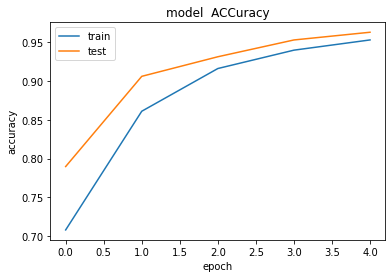

In [57]:
plt.plot(model2_history.history['accuracy'])
plt.plot(model2_history.history['val_accuracy'])
plt.title('model  ACCuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [58]:
pickle.dump(model,open('./web/models/64*64_2.sav','wb'))
model.save('./web/models/50epoch_64*64.h5')


INFO:tensorflow:Assets written to: ram://fda2587e-f419-4610-8566-74fcffb07e64/assets


INFO:tensorflow:Assets written to: ram://fda2587e-f419-4610-8566-74fcffb07e64/assets


Test Accuracy: 83.235%
74/74 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

          nv       0.79      0.99      0.88      1361
         mel       0.95      0.96      0.95       216
         bkl       0.96      0.86      0.91       236
         bcc       0.94      1.00      0.97       104
       akiec       0.98      0.98      0.98        47
        vasc       0.94      1.00      0.97        31
          df       1.00      1.00      1.00        30
         ben       0.00      0.00      0.00       337

    accuracy                           0.83      2362
   macro avg       0.82      0.85      0.83      2362
weighted avg       0.72      0.83      0.77      2362



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

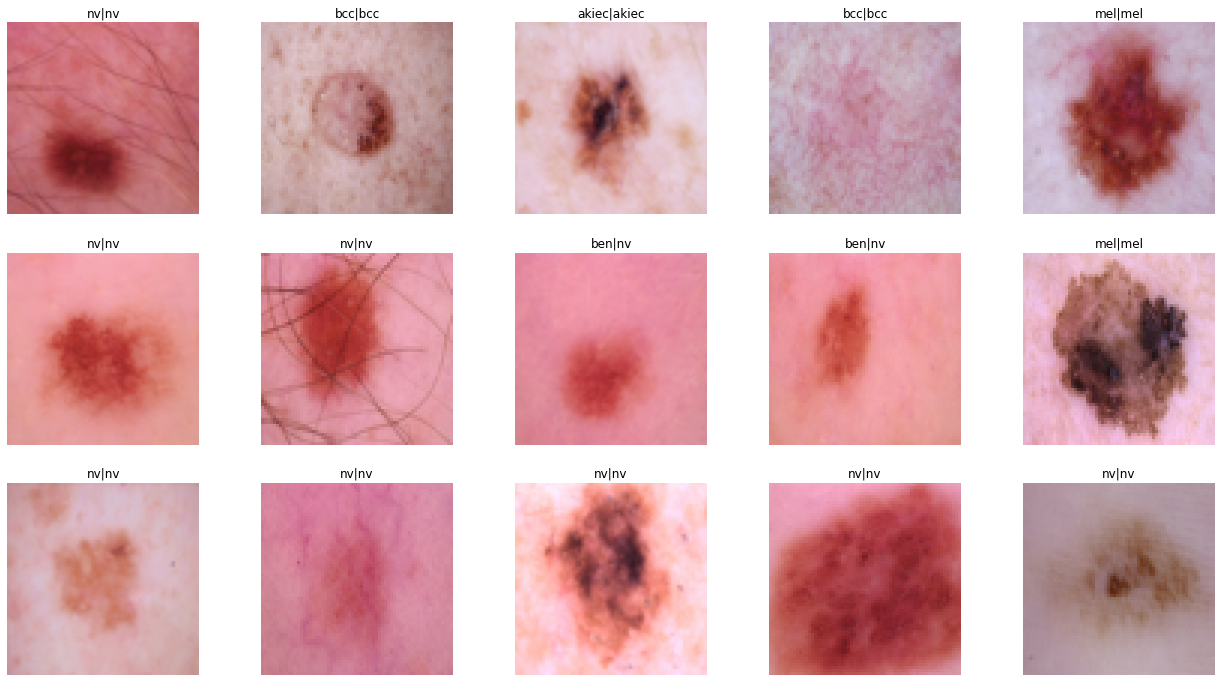

In [59]:
test_model(model, X_test_orig, Y_test_orig)

pratice

In [60]:
# sample_image = cv2.imread('./Pridict Image/melanoma.jpg')

In [61]:
# image_pixels = img_to_array(X_test[ii])
# image_pixels = np.expand_dims(image_pixels,axis=0)
# aged = model.predict(image_pixels)
# print(aged)
# aged = np.argmax(aged)
# print('index no = ',aged)
# age_group = ['0-10','10-20','20-35','35-50','50-60','>60']
# print('age group: ',age_group[aged])

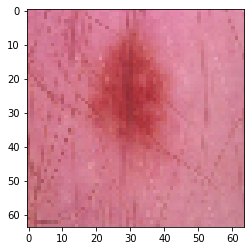

In [62]:

from tensorflow.keras.preprocessing import image
# img = image.load_img('./predict_img/bcc5.jpg',target_size=(75,100))
img = image.load_img('./Datasets/HAM10000/HAM10000_train/1132.jpg',target_size=(64,64))
plt.imshow(img)
plt.show()


In [63]:
img.size

(64, 64)

In [64]:
img = image.img_to_array(img)
img = np.expand_dims(img,axis=0)

In [65]:
loaded_model = pickle.load(open('./web/models/64*64_1.sav', 'rb'))
prediction = loaded_model.predict(img)
# prediction

1/1 [==============================] - 0s 40ms/step


In [66]:
maxElement = np.amax(prediction)
maxElement

0.968164

In [67]:
max_index_row = np.argmax(prediction)
max_index_row
label_mapping = {
    0: 'Melanocytic nevi',
    1: 'melanoma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}
print(label_mapping[max_index_row])

Melanocytic nevi
